In [40]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True, help="path to input image")
# args = vars(ap.parse_args())

In [41]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect
#function for four point transform
def resize(image, width=None,height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w*r), height)
    else:
        r = width / float(w)
        dim = (width, int(h*r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized
#function for resize image

In [42]:
image = cv2.imread("private.jpg")
#scale the image for better OCR
ratio = image.shape[0] / 500.0
orig = image.copy()

image = resize(image, height=500)


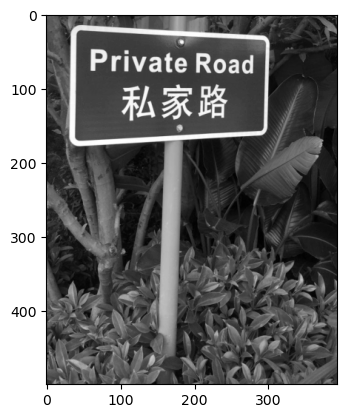

In [43]:
#gray scale the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

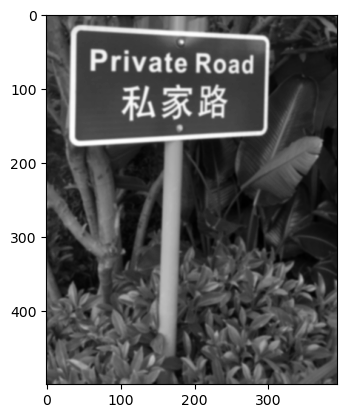

In [44]:
gray = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(gray, cmap='gray')

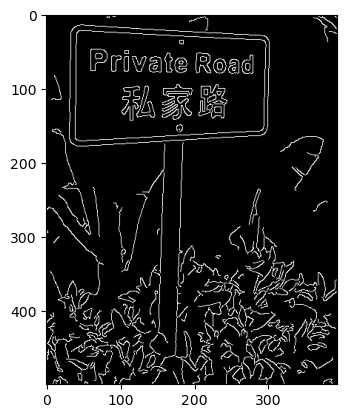

In [45]:
edged = cv2.Canny(gray, 75, 200)
plt.imshow(edged,cmap='gray')

[[[ 35  20]]

 [[ 35 175]]

 [[296 160]]

 [[297  30]]]


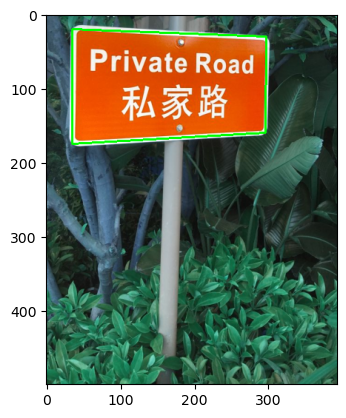

In [46]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
screenCnt = None
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True) #近似多边形
    if len(approx) == 4:
        screenCnt = approx
        break

#Find contours of paper
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image,cmap='gray')
print(screenCnt)

In [47]:
print(screenCnt)
#apply the four point transform to obtain a top-down view of the original image
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

#threshold the image
ref = cv2.threshold(warped,100,255,cv2.THRESH_BINARY)[1]
#cv2.imwrite("scan.jpg", ref)

[[[ 35  20]]

 [[ 35 175]]

 [[296 160]]

 [[297  30]]]


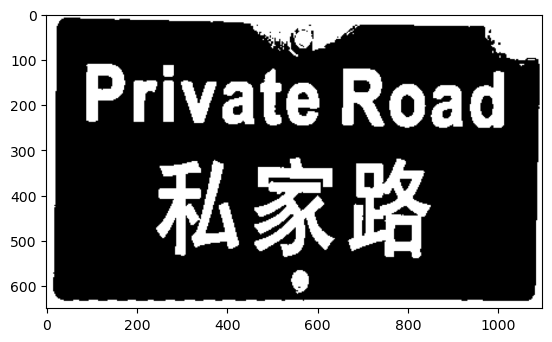

In [48]:
#Apply perspective transform
plt.imshow(resize(orig, height=650))
plt.imshow(resize(ref, height=650), cmap='gray')


In [49]:
import pytesseract
from pytesseract import Output

img = cv2.imread('image.jpg')

d = pytesseract.image_to_data(ref, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [50]:
custom_config = r'--oem 3 --psm 6 -l chi_tra'
print(pytesseract.image_to_string(ref, config=custom_config))

Private Road
私家路



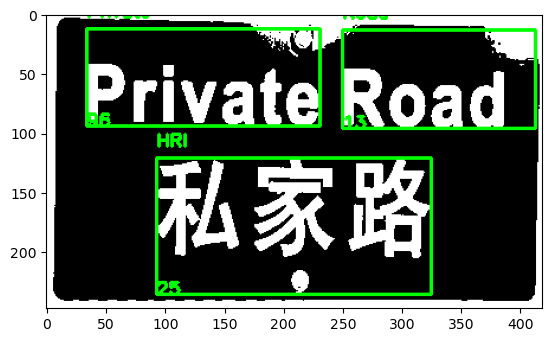

In [51]:
pic1 = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(pic1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = d['text'][i]
        img = cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        tconf = d['conf'][i]
        img = cv2.putText(img, str(tconf), (x, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(img)
plt.show()
